In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
rng = np.random.default_rng()

In [2]:
current_working_directory = os.getcwd()
path = os.path.dirname(current_working_directory)
year = "2019"
result_path = f"{path}/CW/data/Results/"

In [3]:
def impact_resultant_prices(model, trades, prices, decay_factor, estimated_lambda, sigma, ADV, back=False):
    trades_copy = trades.copy()
    if back:
        trades_copy *= -1

    if model == "OW":
        trades_copy = trades_copy
    elif model == "Bouchaud":
        trades_copy = np.sign(trades_copy) * np.sqrt(np.abs(trades_copy))
    elif model == "Reduced":
        trades_copy = np.abs(trades_copy)
    else:
        raise ValueError("Unsupported model")

    # Adjust trades for decay
    trades_copy[1:] /= (1 - decay_factor)

    # Scale trades by price volatility and ADV
    if model == "OW":
        trades_copy *= sigma * estimated_lambda/ ADV
    elif model == "Bouchaud":
        trades_copy *= sigma * estimated_lambda/ np.sqrt(ADV)
    elif model == "Reduced":
        v_t = trades_copy.ewm(alpha=1 - decay_factor, adjust=False).mean()
        trades_copy *= sigma * estimated_lambda/ np.sqrt(ADV * v_t + 1e-10)  # use 1e-10 to avoid division by zero

    Impact = trades_copy.ewm(alpha=1-decay_factor, adjust=False).mean()

    Returns = prices / prices.iloc[0] - 1
    Returns += Impact
    # Return resultant prices
    return prices.iloc[0] * (Returns + 1)

In [4]:
def compute_regression_result(daily_stock_reg_info_df, in_sample_month):
    daily_stock_reg_info_df['date'] = pd.to_datetime(daily_stock_reg_info_df['date'])
    in_sample_df = daily_stock_reg_info_df.loc[daily_stock_reg_info_df["date"].dt.month == in_sample_month]
    out_sample_df = daily_stock_reg_info_df.loc[daily_stock_reg_info_df["date"].dt.month == in_sample_month + 1]

    # for each stock, calculate the sum of x, y, xy, x^2, y^2, and count
    in_sample_result_df = in_sample_df.groupby("stock")[["xy", "x2", "y2", "x", "y", "count"]].sum()
    out_sample_result_df = out_sample_df.groupby("stock")[["xy", "x2", "y2", "x", "y", "count"]].sum()

    in_sample_result_df.columns = "IS_" + in_sample_result_df.columns
    out_sample_result_df.columns = "OOS_" + out_sample_result_df.columns

    result_df = pd.merge(in_sample_result_df, out_sample_result_df, left_index=True, right_index=True, how="inner")

    Cov_x_y = result_df["IS_xy"] - result_df["IS_x"] * result_df["IS_y"] / result_df["IS_count"]
    Var_x = result_df["IS_x2"] - result_df["IS_x"] ** 2 / result_df["IS_count"]
    result_df["lambda_estimate"] = Cov_x_y / Var_x
    result_df["epsilon_estimate"] = result_df["IS_y"] / result_df["IS_count"] - result_df["lambda_estimate"] * result_df["IS_x"] / result_df["IS_count"]
    result_df["IS_SST"] = result_df["IS_y2"] - result_df["IS_y"] ** 2 / result_df["IS_count"]
    result_df["IS_RSS"] = (result_df["IS_count"] * result_df["epsilon_estimate"] ** 2 +
                           2 * result_df["epsilon_estimate"] * result_df["lambda_estimate"] * result_df["IS_x"] -
                           2 * result_df["epsilon_estimate"] * result_df["IS_y"] +
                           result_df["lambda_estimate"] ** 2 * result_df["IS_x2"] -
                           2 * result_df["lambda_estimate"] * result_df["IS_xy"] +
                           result_df["IS_y2"])
    result_df["IS_R2"] = 1 - result_df["IS_RSS"] / result_df["IS_SST"]

    result_df["OOS_SST"] = result_df["OOS_y2"] - result_df["OOS_y"] ** 2 / result_df["OOS_count"]
    result_df["OOS_RSS"] = (result_df["OOS_count"] * result_df["epsilon_estimate"] ** 2 +
                            2 * result_df["epsilon_estimate"] * result_df["lambda_estimate"] * result_df["OOS_x"] -
                            2 * result_df["epsilon_estimate"] * result_df["OOS_y"] +
                            result_df["lambda_estimate"] ** 2 * result_df["OOS_x2"] -
                            2 * result_df["lambda_estimate"] * result_df["OOS_xy"] +
                            result_df["OOS_y2"])
    result_df["OOS_R2"] = 1 - result_df["OOS_RSS"] / result_df["OOS_SST"]

    return result_df

In [5]:
num_days_precompute = 20
filename = f"inter_results_stock_info_df_{year}all.csv"
stock_info_df = pd.read_csv(result_path+filename)
stacked_info = stock_info_df.pivot(index="date", columns="stock", values=["px_vol", "volume"]).rolling(num_days_precompute).mean().shift(1)
scaling_df = pd.DataFrame({
    "px_vol": stacked_info["px_vol"].unstack(),
    "volume": stacked_info["volume"].unstack(),
}).reset_index()

asset = "AAPL"
dates = "2019-03-14"

ssdf = scaling_df[(scaling_df["stock"] == asset) & (scaling_df["date"] == dates)]
price_vol = ssdf["px_vol"]
ADV = ssdf["volume"]
decay = np.exp(-np.log(2) / 3600 * 10)

month = dates.split("-")[1]
in_sample = int(month) - 1

filename = f"inter_results_px_df_{2019}{month}.csv"
px_df = pd.read_csv(result_path+filename).set_index(["stock","date"])
filename = f"inter_results_trade_volume_df_{2019}{month}.csv"
volumes = pd.read_csv(result_path+filename).set_index(["stock","date"])
prices = px_df.loc[(asset,dates)]
trades = volumes.loc[(asset,dates)]

In [7]:
filename = f"OW_reg_info_{year}_horizon{1}_beta{60}mins.csv"
test_OW = pd.read_csv(result_path+filename)
res_ow = compute_regression_result(test_OW, in_sample)
res_ow = res_ow.loc[asset]

In [8]:
def synthetic_alpha_generator(rho: float, prices: pd.DataFrame, horizon: int):
    """
    rho: correlation
    horizon: number of 10 seconds
    prices: impact-adjusted prices
    """
    x = rho ** 2
    returns = prices.pct_change(horizon)
    var = returns.var()
    p_minus2 = 1/(prices**2)
    p_minus_mean = p_minus2.mean()
    h = horizon
    y = rho * np.sqrt(1-rho**2)*np.sqrt(var/(h*p_minus_mean))
    normal = rng.normal(loc = 0, scale = h, size = prices.shape)
    res = x * returns + y * normal / prices
    
    return res.fillna(0),returns

In [9]:
def synthetic_alpha(rho, asset, dates):
    """
    rho: correlation
    asset: name of stock
    dates: date of trade
    """
    ssdf = scaling_df[(scaling_df["stock"] == asset) & (scaling_df["date"] == dates)]
    price_vol = ssdf["px_vol"]
    ADV = ssdf["volume"]
    decay = np.exp(-np.log(2) / 3600 * 10)

    month = dates.split("-")[1]
    in_sample = int(month) - 1

    filename = f"inter_results_px_df_{2019}{month}.csv"
    px_df = pd.read_csv(result_path+filename).set_index(["stock","date"])
    filename = f"inter_results_trade_volume_df_{2019}{month}.csv"
    volumes = pd.read_csv(result_path+filename).set_index(["stock","date"])
    prices = px_df.loc[(asset,dates)]
    trades = volumes.loc[(asset,dates)]
    filename = f"OW_reg_info_{year}_horizon{1}_beta{60}mins.csv"
    test_OW = pd.read_csv(result_path+filename)
    res_ow = compute_regression_result(test_OW, in_sample)
    res_ow = res_ow.loc[asset]

    S = impact_resultant_prices("OW", trades, prices, decay, res_ow["lambda_estimate"], price_vol.values, ADV.values)
    alpha,returns = synthetic_alpha_generator(rho, S, 1)
    alpha = alpha.shift(6).fillna(0)
    return alpha,returns,price_vol,ADV, res_ow["lambda_estimate"],S

In [10]:
def smooth_alpha(alpha, time_unit = 10):
    smoothed = alpha.ewm(halflife=200).mean()
    deriv_1 = smoothed.diff(1).shift(-1).fillna(0) / time_unit
    deriv_2 = smoothed.diff(1).diff(1).shift(-1).fillna(0) / (time_unit ** 2)
    return smoothed[200:], deriv_1[200:], deriv_2[200:]

In [11]:
def optimal_trade(alpha, half_life, px_vol, ADV, impact_coef, time_unit = 10, model = "OW"):
    beta = np.log(2)/half_life
    decay_factor = np.exp(-beta * time_unit)
    if model == "Reduced":
        pass
    elif model == "OW":
        smoothed, deriv_1, deriv_2 = smooth_alpha(alpha)
        optimal_impact = 0.5 * (smoothed - deriv_1 / beta)
        optimal_impact.iloc[-1] = smoothed.iloc[-1]
        optimal_trades = beta * (smoothed - deriv_2/ (beta ** 2 )) / (px_vol.values / ADV.values * impact_coef) / 2 * time_unit
        optimal_trades.iloc[0] = optimal_impact.iloc[0] / (px_vol / ADV * impact_coef) # I_0^* / lambda
        optimal_trades.iloc[-1] += (smoothed.iloc[-1] - optimal_impact.iloc[-2] * decay_factor) / (px_vol.values / ADV.values * impact_coef)
        
        pct_synthetic_alpha_optimal_trades = optimal_trades / ADV.values
        total_trade_sizes = abs(pct_synthetic_alpha_optimal_trades).sum() # if df then axis = 1
        
        return optimal_trades,optimal_impact,pct_synthetic_alpha_optimal_trades, total_trade_sizes

In [12]:
num_days_precompute = 20
filename = f"inter_results_stock_info_df_{year}all.csv"
stock_info_df = pd.read_csv(result_path+filename)
stacked_info = stock_info_df.pivot(index="date", columns="stock", values=["px_vol", "volume"]).rolling(num_days_precompute).mean().shift(1)
scaling_df = pd.DataFrame({
    "px_vol": stacked_info["px_vol"].unstack(),
    "volume": stacked_info["volume"].unstack(),
}).reset_index()



In [13]:
asset = "AAPL"
date_list = ['2019-03-14', '2019-03-15', '2019-03-18', '2019-03-19',
    '2019-03-20', '2019-03-21', '2019-03-22', '2019-03-25',
    '2019-03-26', '2019-03-27', '2019-03-28', '2019-03-29',
    '2019-04-01', '2019-04-02', '2019-04-03', '2019-04-04',
    '2019-04-05', '2019-04-08', '2019-04-09', '2019-04-10',
    '2019-04-11', '2019-04-12', '2019-04-15', '2019-04-16',
    '2019-04-17', '2019-04-18']
rho = 0.1
def func():
    l=[]
    for dates in date_list:
        alpha,returns,price_vol, ADV, res_ow_beta,S = synthetic_alpha(rho, asset, dates)
        alpha = alpha.cumsum()
        returns = returns.cumsum()
        smoothed, deriv_1, deriv_2 = smooth_alpha(alpha)
        opt_trades, opt_impact, volume_pct,sizes = optimal_trade(alpha, 3600, price_vol, ADV, res_ow_beta, time_unit = 10, model = "OW")
        l.append((opt_trades, opt_impact, volume_pct, sizes,S,smoothed,returns))
    return l


In [14]:
l= func()

C:\Users\zkr_l\AppData\Local\Temp\ipykernel_2632\1301893758.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ -4748496.00680968  -3336008.19747074   -763169.71075067 ...
   4737578.72893109 -36989297.06377441         0.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trades_copy[1:] /= (1 - decay_factor)
C:\Users\zkr_l\AppData\Local\Temp\ipykernel_2632\1301893758.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-5722733.08987967   493876.85641222   268772.98396328 ...
  4301407.48416283 -3378637.56823474        0.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trades_copy[1:] /= (1 - decay_factor)
C:\Users\zkr_l\AppData\Local\Temp\ipykernel_2632\1301893758.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and 

In [15]:
corr = [(l[i][5]).corr(l[i][6]) for i in range(len(l))]
print(corr)

[0.45330685449073654, 0.2290045863638908, 0.21807611829333567, -0.5928729366806885, 0.7470592741058757, -0.24181749738177968, 0.2555365052104046, 0.6624803627649894, -0.8851203624584876, -0.18088333265181547, 0.12597728817503215, -0.4910148277701743, -0.6081708051730923, 0.6379038420292872, -0.743957513113167, 0.2607931153940006, 0.3190997281500909, -0.4496469106173674, 0.7172104073202711, 0.014047852489951244, 0.186014310389287, 0.5071180381981274, -0.431780621198924, -0.5741463655421009, 0.5256432875265205, 0.8123219191530305]


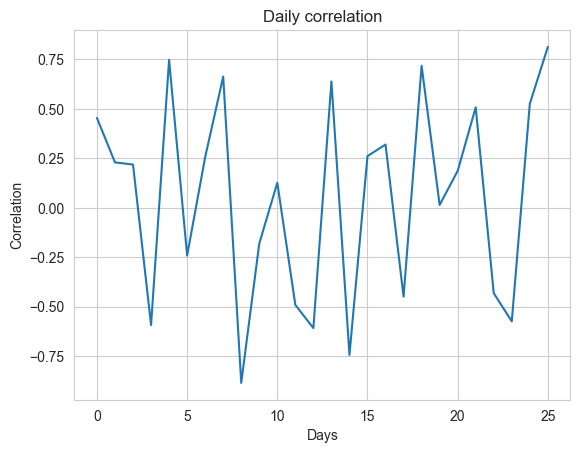

In [16]:
plt.plot(corr)
plt.title('Daily correlation')
plt.xlabel('Days')  
plt.ylabel('Correlation')  
plt.show()

In [17]:
def calculate_pnl(trades, prices,optimal_impact):
    cum_trades = trades.cumsum()
    gain = prices.iloc[-1]*cum_trades.iloc[-1] - prices * trades.shift(-1)
    impact_cost = -optimal_impact * trades.shift(-1)
    pnl = (gain + impact_cost).fillna(0).cumsum()
    notional = (trades.abs() * prices).sum()
    pnl =  pnl/notional
    return pnl


In [18]:
pnls = []
for item in l:
    temp = calculate_pnl(item[0],item[4],item[1])[-1]
    print(temp)
    pnls.append(temp)
print(pnls)    

11.49624832373739
64.00551081914791
49.49835387827423
85.16291648275406
80.69933903776663
-100.10460566508294
14.471326632307834
-72.41185485710687
139.45389942622225
-54.309171684799175
157.81891501315278
-127.78208686262906
-79.92549909699048
-71.50375767830234
98.31717856753586
105.59248230448378
36.06532206896087
-77.75754797574189
-102.56563761386872
-21.885008579633766
-110.6880103164461
39.2740207887832
-75.90454433732643
-15.559840128776443
149.2015234428372
76.49199933756789
[11.49624832373739, 64.00551081914791, 49.49835387827423, 85.16291648275406, 80.69933903776663, -100.10460566508294, 14.471326632307834, -72.41185485710687, 139.45389942622225, -54.309171684799175, 157.81891501315278, -127.78208686262906, -79.92549909699048, -71.50375767830234, 98.31717856753586, 105.59248230448378, 36.06532206896087, -77.75754797574189, -102.56563761386872, -21.885008579633766, -110.6880103164461, 39.2740207887832, -75.90454433732643, -15.559840128776443, 149.2015234428372, 76.49199933756

C:\Users\zkr_l\AppData\Local\Temp\ipykernel_2632\267309378.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp = calculate_pnl(item[0],item[4],item[1])[-1]
C:\Users\zkr_l\AppData\Local\Temp\ipykernel_2632\267309378.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp = calculate_pnl(item[0],item[4],item[1])[-1]
C:\Users\zkr_l\AppData\Local\Temp\ipykernel_2632\267309378.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tem

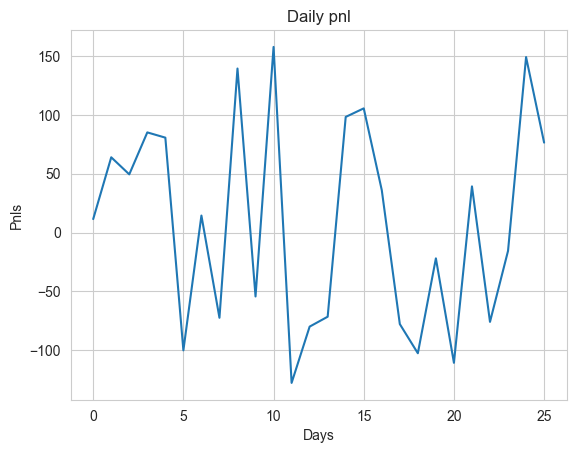

In [19]:
plt.plot(pnls)
plt.title('Daily pnl')
plt.xlabel('Days')  
plt.ylabel('Pnls')  
plt.show()

In [20]:
sharpe = []
for item in l:
    temp = calculate_pnl(item[0],item[4],item[1])
    temp = np.array(temp)
    index1 = np.nonzero(temp)
    temp = temp[index1]
    ret = (temp[1:]-temp[:-1])/temp[:-1]
    ret = np.array(ret)
    average_ret = np.nanmean(ret)
    excess_return = average_ret - 0.01/252
    stdd = np.nanstd(ret)
    
    sharpe_ratio = excess_return/stdd
    sharpe.append(sharpe_ratio)
print(sharpe)
    

[0.1529695051529833, 0.13199267217721455, 0.1354407329982205, 0.14144545122061158, 0.14063394785117297, 0.14052957139577207, 0.1304816896713432, 0.1395813904661098, 0.13935229933312016, 0.13684866646617228, 0.13836114217053974, 0.1384445390068853, 0.13626483378656065, 0.1378382474015733, 0.14028007179816593, 0.14040856621701733, 0.13692664956385087, 0.14277631842275237, 0.14011772213321258, 0.16293139381934083, 0.13794570153257135, 0.13667240700749095, 0.14358391755570152, 0.127389390604265, 0.13906493588913968, 0.13930787822236604]


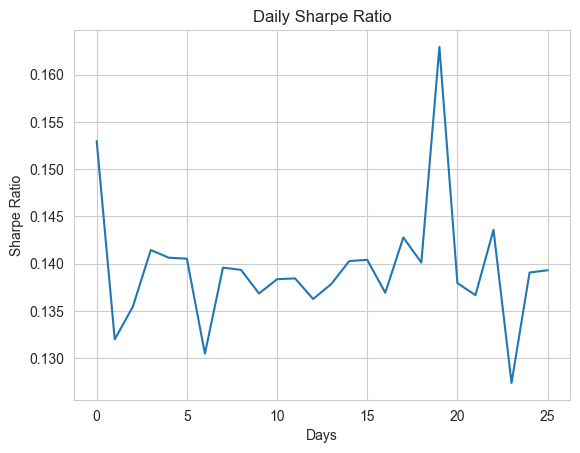

In [21]:
plt.plot(sharpe)
plt.title('Daily Sharpe Ratio')
plt.xlabel('Days') 
plt.ylabel('Sharpe Ratio') 
plt.show()

In [22]:
transaction_cost = []
for i in range(len(l)):
    temp = (l[i][4])*(l[i][0]).abs()*0.002+(0.5+0.05)*(l[i][0]).abs()
    transaction_cost.append(temp.mean())
print(transaction_cost)

[345.78528003293866, 363.3142416148363, 322.8392551954704, 429.2108948994243, 435.2404411331181, 550.1917656246015, 612.5405719384639, 692.1008480713524, 652.7541562942926, 558.2692940236617, 406.2011633225956, 436.26420979981276, 495.4288015940791, 390.3784710621885, 425.0396537725118, 385.22949803852504, 342.3445645285672, 698.99138457937, 499.81039231500466, 428.29596240962417, 392.85225797722563, 450.4091899867388, 321.2036810932818, 476.82188819468655, 461.2927651084304, 352.02445188113023]


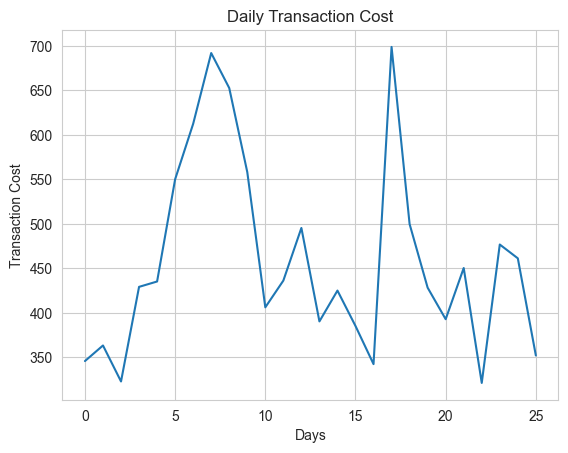

In [23]:
plt.plot(transaction_cost)
plt.title('Daily Transaction Cost')
plt.xlabel('Days')  # Label for the X-axis
plt.ylabel('Transaction Cost')  # Label for the Y-axis
plt.show()

In [24]:
mdd = []
for item in l:
    temp = calculate_pnl(item[0],item[4],item[1])
    temp = np.array(temp)
    peaks = np.maximum.accumulate(temp)
    dds = np.divide(temp - peaks, np.where(peaks == 0, 1, peaks))
    mdds = dds.min() 
    mdd.append(mdds)    
    
print(mdd)

[0.0, 0.0, 0.0, 0.0, 0.0, -100.10460566508294, 0.0, -72.41185485710687, 0.0, -54.309171684799175, 0.0, -127.78208686262906, -79.92549909699048, -71.50375767830234, 0.0, 0.0, 0.0, -77.75754797574189, -102.56563761386872, -21.885008579633766, -110.6880103164461, 0.0, -75.90454433732643, -15.559840128776443, 0.0, 0.0]


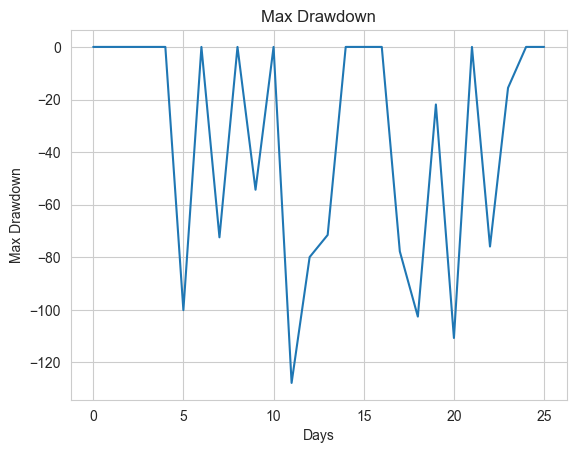

In [25]:
plt.plot(mdd)
plt.title('Max Drawdown')
plt.xlabel('Days')  # Label for the X-axis
plt.ylabel('Max Drawdown')  # Label for the Y-axis
plt.show()